In [1]:
from scipy.constants import epsilon_0
epsilon_0

%matplotlib notebook
import matplotlib.pyplot as plt
# print(plt.style.available)  # show available template
plt.style.use(['seaborn-ticks','seaborn-paper'])  # use a templet

import matplotlib as mpl
# mpl.rcParams['lines.linewidth'] = 2
# mpl.rcParams['lines.color'] = 'r'
params = {
    'figure.figsize': [8, 6], # Note! figure unit is inch!  scale fontz size 2.54 to looks like unit cm
    'axes.labelsize': 7*2.54, # scale 2.54 to change to figure unit looks as cm
    'font.size':  6*2.54,
    'lines.linewidth':2,
    'legend.fontsize': 7*2.54,
    'xtick.labelsize': 5*2.54,
    'ytick.labelsize': 5*2.54,
    'text.usetex': False,  
    'xtick.direction': "in",
    'ytick.direction': "in", # ticket inside
    'legend.frameon' : True, 
    'legend.edgecolor': 'black',
    'legend.shadow': True,
    'legend.framealpha':1,
#     'patch.linewidth' : 0.5, 
}
mpl.rcParams.update(params)
# mpl.rcParams.items()
# other package import
import matplotlib.cbook as cbook
from matplotlib_scalebar.scalebar import ScaleBar

import numpy as np
from qutip import *
import itertools

In [2]:
def GenOmega(laserPolarization, s):
    # laserPolarization:  (pi, sigma_plus, sigma_minus) compoment
    # s saturation parameter
    
    linewidth = 19.7 * 1e6  # Hz
    pi, sigma_plus, sigma_minus = laserPolarization
    _omega = 2 * np.pi *linewidth * np.sqrt(s)

    omega = np.zeros((8, 8))
    omega[0][7] = omega[7][0] = \
    omega[1][4] = omega[4][1] = \
    omega[1][6] = omega[6][1] = \
    omega[2][7] = omega[7][2] = _omega * sigma_plus

    omega[0][5] = omega[5][0] = \
    omega[2][5] = omega[5][2] = \
    omega[3][4] = omega[4][3] = \
    omega[3][6] = omega[6][3] = _omega * sigma_minus

    omega[0][6] = omega[6][0] = \
    omega[1][5] = omega[5][1] = \
    omega[2][4] = omega[4][2] = \
    omega[3][7] = omega[7][3] = _omega * pi
    
    return omega


def Hamiltonian(tau, s, Delta, delta, B):
    # tau; time of chirp
    # s ：saturation parameter
    # detuning： \Delta   GHz
    # delta：    \delta   GHz
    
    # spontanouse decay rate
    linewidth = 19.7 * 1e6  # Hz
    
    # hyperfine splitting
    s_splitting = 12642.812118466  # MHz
    p_splitting = 2105  # MHz
    quadratic_shift = 310.8  # B**2 Hz (B in Gauss)
    
    mF = np.zeros(8)
    mF[1] = -1
    mF[3] = 1
    mF[5] = -1
    mF[7] = 1
    
    cg = np.zeros((8, 8))
    # pi transitions
    cg[0][6] = cg[6][0] = 1 / np.sqrt(3)
    cg[1][5] = cg[5][1] = -1 / np.sqrt(3)
    cg[2][4] = cg[4][2] = 1 / np.sqrt(3)
    cg[3][7] = cg[7][3] = 1 / np.sqrt(3)

    # sigma+ transitions
    cg[0][7] = cg[7][0] = -1 / np.sqrt(3)
    cg[1][4] = cg[4][1] = 1 / np.sqrt(3)
    cg[1][6] = cg[6][1] = 1 / np.sqrt(3)
    cg[2][7] = cg[7][2] = 1 / np.sqrt(3)

    # sigma- transitions
    cg[0][5] = cg[5][0] = -1 / np.sqrt(3)
    cg[2][5] = cg[5][2] = -1 / np.sqrt(3)
    cg[3][4] = cg[4][3] = 1 / np.sqrt(3)
    cg[3][6] = cg[6][3] = -1 / np.sqrt(3)
    
    alpha = (Delta-12.642)/(Delta+12.642)
#     alpha_p = np.sqrt(np.sqrt(((alpha**2 -1)**2 /2)**2 + alpha**2) + (alpha**2 -1)**2 /2)
#     alpha_s = np.sqrt(np.sqrt(((alpha**2 -1)**2 /2)**2 + alpha**2) - (alpha**2 -1)**2 /2)
#     sat_x= s*alpha_p
#     sat_y= s*alpha_s/alpha
    
    sat_x= s
    sat_y= s/alpha    
    
    def delta_coeff(t, args):  #双光子失谐
        return 2*np.pi*delta*1e9*np.cos(np.pi*t/tau)

    def sat_coeff(t, args):   #波形
        return np.sin(np.pi*t/tau)
    
    # X line porlar light : sigma_+ + sigma_-
    Polarization_x = (0, 1/np.sqrt(2), 1/np.sqrt(2))
    omega = GenOmega(Polarization_x, sat_x)
    
    off_diagonal_elements = 0
    for i, j in itertools.product(range(8),range(8)):
        off_diagonal_elements += omega[i][j] / 2 * cg[i][j]**2 * basis(8,i) * basis(8,j).dag()
        
    # Y line porlar light : sigma_+ - sigma_-
    Polarization_y = (0, 1/np.sqrt(2), -1/np.sqrt(2))
    omega = GenOmega(Polarization_y, sat_y)
    for i, j in itertools.product(range(8),range(8)):
        off_diagonal_elements += omega[i][j] / 2 * cg[i][j] ** 2 * basis(8,i) * basis(8,j).dag()

    
    ee = np.sum(basis(8,i) * basis(8,i).dag() for i in (4, 5, 6, 7))
    g1 = np.sum(basis(8,i) * basis(8,i).dag() for i in (1,2,3))
    g0 = basis(8,0) * basis(8,0).dag()
    
    ee_shifts = 2 * np.pi*0.47e6*B*(mF[5]* basis(8,5) * basis(8,5).dag()+\
                                      mF[7]* basis(8,7) * basis(8,7).dag())- 2*np.pi*p_splitting*1e6*basis(8,4) * basis(8,4).dag()
    g1_shifts = 2 * np.pi*1.4e6*B*(mF[1]* basis(8,1) * basis(8,1).dag()+\
                                      mF[3]* basis(8,3) * basis(8,3).dag())
    g0_shifts = 2 * np.pi * quadratic_shift * B ** 2* basis(8,0) * basis(8,0).dag()

    
    diagonal_elements= 2*np.pi*Delta*1e9*(ee-g1) + 2*np.pi*Delta*1e9*(ee-g0) + (ee_shifts-g1_shifts) + (ee_shifts-g0_shifts)
    diagonal_elements/=2.0
    

    c_ops = []
    for i in range(4):
        c_ops.append (np.sqrt(2 * np.pi * linewidth) * cg[i][4]* basis(8,i) * basis(8,4).dag())
    for i in range(4):
        c_ops.append (np.sqrt(2 * np.pi * linewidth) * cg[i][5]* basis(8,i) * basis(8,5).dag())
    for i in range(4):
        c_ops.append (np.sqrt(2 * np.pi * linewidth) * cg[i][6]* basis(8,i) * basis(8,6).dag())
    for i in range(4):
        c_ops.append (np.sqrt(2 * np.pi * linewidth) * cg[i][7]* basis(8,i) * basis(8,7).dag())
        
    
    H = [diagonal_elements,[(-ee+g0)/2.0,delta_coeff],[off_diagonal_elements,sat_coeff]]
    
    return (H, c_ops)

In [487]:
psi0=basis(8,0) #initial state
population = basis(8,2)*basis(8,2).dag()
H, c_ops = Hamiltonian(0.2e-9,20e6,121.5,7.05,10)
t = np.linspace(0, 0.2e-9, 500)
output = mesolve(H, psi0, t, c_ops, population)
t1 = np.linspace(0, 2e-9, 500) 
output2 = mesolve(H, psi0, t1, c_ops, population)



/Users/apple/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/Users/apple/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:98: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


In [488]:
psi1 = basis(8,2) #initial state
population1 = basis(8,2)*basis(8,2).dag()
H, c_ops = Hamiltonian(0.2e-9,20e6,121.5,7.05,10)
t = np.linspace(0, 0.2e-9, 500)
output1 = mesolve(H, psi1, t, c_ops, population)
t1 = np.linspace(0, 2e-9, 500) 
output3 = mesolve(H, psi1, t1, c_ops, population)


/Users/apple/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/Users/apple/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:98: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


<IPython.core.display.Javascript object>


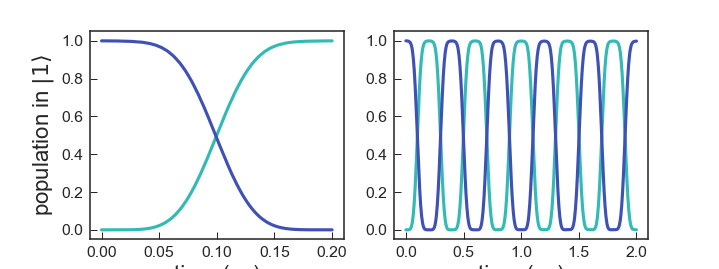

In [498]:
plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
plt.plot(t*1e9,output.expect[0], linewidth=2.5 ,c='#32bab5')
plt.plot(t*1e9,output1.expect[0], linewidth=2.5 ,c='#3F51B5')
plt.ylabel('population in '+r'$|1\rangle$')
plt.xlabel(r"time (ns)")
plt.subplot(1,2,2)
plt.plot(t1*1e9,output2.expect[0], linewidth=2.5 ,c='#32bab5')
plt.plot(t1*1e9,output3.expect[0], linewidth=2.5 ,c='#3F51B5')
# plt.ylabel('population in '+r'$|1\rangle$')
plt.xlabel(r"time (ns)")
plt.savefig('../fig/f3.pdf')

In [503]:
rx = basis(8, 0) * basis(8, 2).dag() + basis(8, 2) * basis(8, 0).dag()
ry = 1j * (basis(8, 0) * basis(8, 2).dag() - basis(8, 2) * basis(8, 0).dag())
rz = basis(8, 0) * basis(8, 0).dag() - basis(8, 2) * basis(8, 2).dag()
H, c_ops = Hamiltonian(0.2e-9,20e6,121.5,7.05,10)
t = np.linspace(0, 2e-9, 500)
bloch_vectors = mesolve(H, psi0, t, c_ops, [rx, ry, rz])

/Users/apple/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/Users/apple/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:98: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


<IPython.core.display.Javascript object>


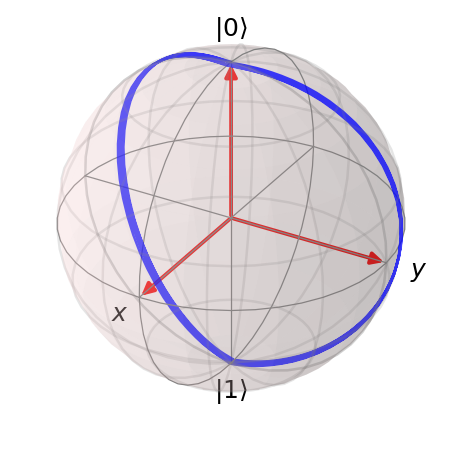

In [505]:
b = Bloch()
vec = [[1, 0, 0], [0, 1, 0], [0, 0, 1]]
b.add_vectors(vec)
b.add_points([bloch_vectors.expect[0], bloch_vectors.expect[1], bloch_vectors.expect[2]], meth='l')
b.vector_color = 'r'
b.size = [3,3]
b.show()
plt.savefig('../fig/bloch4.pdf')


In [238]:
ss = np.linspace(1, 6, 200)
delta = 3.75
psi0=basis(8,0) #initial state
population=basis(8,2)*basis(8,2).dag()
t = np.linspace(0, 1.2e-9, 200)
tao = 1e-9
f_30 = np.zeros(200)
f_60 = np.zeros(200)
f_90 = np.zeros(200)
f_120 = np.zeros(200)
for i,s in enumerate(ss):
    H_30, c_ops_30 = Hamiltonian(tao, s*1e6, 30, delta, 10)
    output_30 = mesolve(H_30, psi0, t, c_ops_30, population)
    f_30[i] = 1 - max(output_30.expect[0])
    H_60, c_ops_60 = Hamiltonian(tao, s*1e6, 60, delta, 10)
    output_60 = mesolve(H_60, psi0, t, c_ops_60, population)
    f_60[i] = 1 - max(output_60.expect[0])
    H_90, c_ops_90 = Hamiltonian(tao, s*1e6, 90, delta, 10)
    output_90 = mesolve(H_90, psi0, t, c_ops_90, population)
    f_90[i] = 1 - max(output_90.expect[0]) 
    H_120, c_ops_120 = Hamiltonian(tao, s*1e6, 120, delta, 10)
    output_120 = mesolve(H_120, psi0, t, c_ops_120, population)
    f_120[i] = 1 - max(output_120.expect[0])

/Users/apple/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/Users/apple/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:98: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


In [334]:
psi0=basis(8,0) #initial state
population=basis(8,2)*basis(8,2).dag()
# H, c_ops = Hamiltonian(0.6e-9,10e6,120,8.75,10)
# output = mesolve(H, psi0, t, c_ops, population)
# tao = 1e-9
# Delta = 120 #GHz
t = np.linspace(0, 1e-9, 20)

array_30 = np.zeros((50,50))
ss = np.linspace(1,15,50) 
DELTA = np.linspace(3,12,50)
for i,s in enumerate(ss):
    for j,delta in enumerate(DELTA):
        H, c_ops = Hamiltonian(1e-9, s*1e6,30, delta, 10)  
        output = mesolve(H, psi0, t, c_ops, population)
        array_30[i][j] = np.log10(1-max(output.expect[0]))
        

/Users/apple/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/Users/apple/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:98: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


<IPython.core.display.Javascript object>


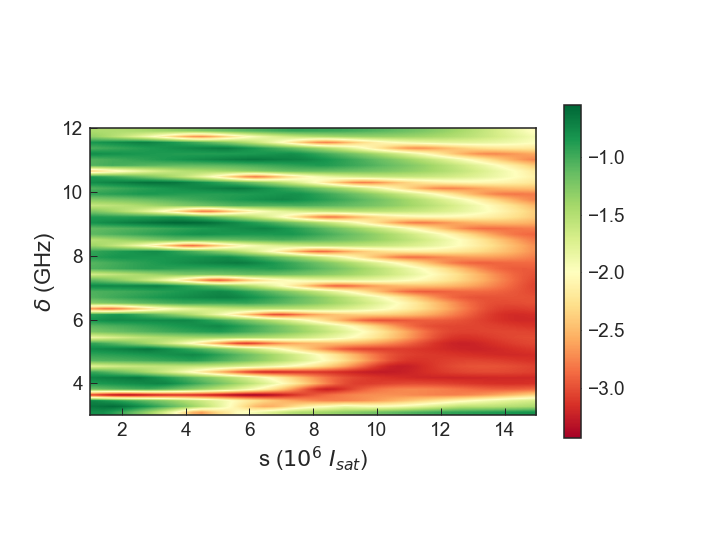

In [340]:
plt.figure()
plt.imshow(array_30, interpolation='bilinear', cmap=cm.RdYlGn,
               origin='lower', extent=[1, 15, 3, 12])
plt.xlabel('s ($10^{6}\ I_{sat}$)')
plt.ylabel(r'$\delta$'+' (GHz)')
plt.colorbar(shrink=.8)
plt.savefig('../fig/f2.pdf')

<IPython.core.display.Javascript object>


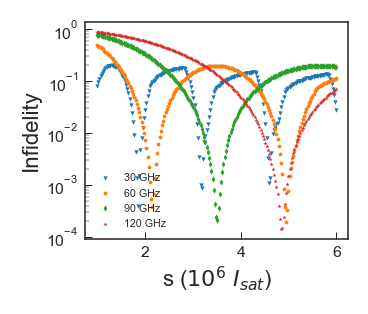

In [593]:
fig, ax = plt.subplots(figsize=(4.1, 3.5))
ss = np.linspace(1, 6, 200)
plt.semilogy(ss,f_30,'v',label='30 GHz',ms=3.5)
plt.semilogy(ss,f_60,'p',label='60 GHz',ms=3.5)
plt.semilogy(ss,f_90,'d',label='90 GHz',ms=3.5)
plt.semilogy(ss,f_120,'*',label='120 GHz',ms=3.5)
plt.xlabel('s ($10^{6}\ I_{sat}$)')
plt.ylabel('Infidelity')
plt.legend(prop = {'size':8.5},frameon=False)
plt.tight_layout()
plt.savefig('../fig/f6.pdf')

<IPython.core.display.Javascript object>


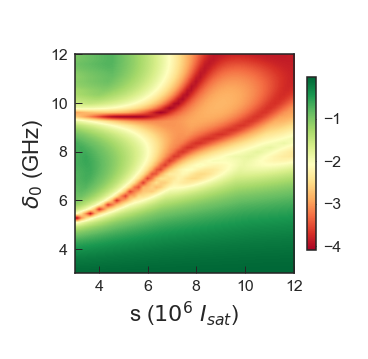

In [586]:
# plt.figure()
# plt.imshow(array, origin='lower', cmap=plt.get_cmap('hot'))
# plt.colorbar()
# plt.show()
import matplotlib.cm as cm
fig1, ax1 = plt.subplots(figsize=(4.1, 4))
plt.imshow(array, interpolation='bilinear', cmap=cm.RdYlGn,
               origin='lower', extent=[3, 12, 3, 12])
plt.xlabel('s ($10^{6}\ I_{sat}$)')
plt.ylabel(r'$\delta_0$'+' (GHz)')
plt.xticks([4,6,8,10,12],(4,6,8,10,12))
# fig.colorbar(im, ax=axs[1])
plt.colorbar(shrink=.6)
plt.tight_layout()
plt.savefig('../fig/f7.pdf')

In [464]:
import pandas as pd
import numpy as np
data = { '30' : f_30, '60' : f_60, '90' : f_90, '120' : f_120 }
df.to_csv('Infidelity_with_different-intensity.csv')

<IPython.core.display.Javascript object>


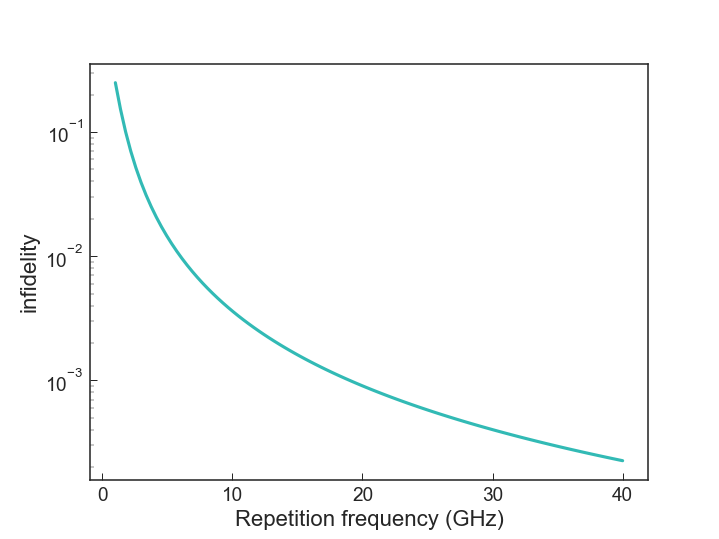

In [472]:
iff = [0.75096949, 0.84749486, 0.89978349, 0.92989822, 0.94848623,
       0.96065877, 0.96902428, 0.97500392, 0.97941853, 0.98276659,
       0.98536402, 0.98741844, 0.98907067, 0.99041884, 0.99153299,
       0.99246415, 0.99325019, 0.9939197 , 0.99449458, 0.99499181,
       0.99542476, 0.99580401, 0.99613809, 0.99643388, 0.996697  ,
       0.9969321 , 0.997143  , 0.99733291, 0.99750453, 0.99766013,
       0.99780164, 0.9979307 , 0.99804875, 0.99815698, 0.99825647,
       0.99834812, 0.99843274, 0.99851103, 0.9985836 , 0.998651  ,
       0.9987137 , 0.99877214, 0.99882669, 0.99887769, 0.99892543,
       0.9989702 , 0.99901222, 0.99905173, 0.99908892, 0.99912396,
       0.99915702, 0.99918825, 0.99921777, 0.99924572, 0.99927219,
       0.99929729, 0.99932112, 0.99934376, 0.99936528, 0.99938576,
       0.99940527, 0.99942386, 0.9994416 , 0.99945853, 0.9994747 ,
       0.99949015, 0.99950494, 0.99951909, 0.99953264, 0.99954563,
       0.99955808, 0.99957003, 0.9995815 , 0.99959251, 0.9996031 ,
       0.99961328, 0.99962307, 0.9996325 , 0.99964158, 0.99965032,
       0.99965875, 0.99966687, 0.99967471, 0.99968228, 0.99968958,
       0.99969664, 0.99970345, 0.99971004, 0.99971641, 0.99972258,
       0.99972854, 0.99973432, 0.99973991, 0.99974532, 0.99975057,
       0.99975566, 0.99976059, 0.99976538, 0.99977002, 0.99977453]
iff = np.array(iff)
plt.subplots()
plt.semilogy(np.linspace(1,40,100),1-iff,color ="#32bab5",lw=2.5)
plt.xticks((0,10,20,30,40),[0,10,20,30,40])
plt.xlabel('Repetition frequency (GHz)')
plt.ylabel('infidelity')
plt.savefig('../fig/f5.pdf')



In [3]:
psi0=basis(8,0) #initial state
population=basis(8,2)*basis(8,2).dag()
# H, c_ops = Hamiltonian(0.6e-9,10e6,120,8.75,10)
# output = mesolve(H, psi0, t, c_ops, population)
# tao = 1e-9
# Delta = 120 #GHz
tt = np.linspace(50,100,50) # GHz
ss = np.linspace(30,80,50) 
array_t = np.zeros((50,50))
for i,t in enumerate(tt):
    for j,s in enumerate(ss):
        tao = t/1e12
        T = np.linspace(0,tao,20)
        H, c_ops = Hamiltonian(tao, s*1e6, 121.5,7.05, 10)
        output = mesolve(H, psi0, T, c_ops, population)
        array_t[i][j] = np.log10(1-max(output.expect[0]))


/Users/apple/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/Users/apple/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:98: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


<IPython.core.display.Javascript object>


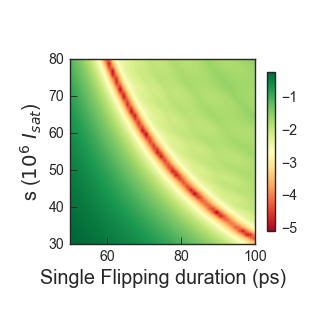

In [11]:
fig, ax = plt.subplots(figsize=(4,4))
import matplotlib.cm as cm
plt.imshow(array_t*1.3, interpolation='bilinear', cmap=cm.RdYlGn,
               origin='lower', extent=[50, 100, 30, 80])
plt.xlabel('Single Flipping duration (ps)')
plt.ylabel('s ($10^{6}\ I_{sat}$)')
plt.colorbar(shrink=.6)
plt.tight_layout()
plt.savefig('../fig/f10.pdf')


In [7]:
import pandas as pd
import numpy as np
df = pd.DataFrame(array_t,index = np.around(ff,decimals=2),columns = np.around(ss,decimals=2))
df.to_csv('Infidelity_with_repetition rate_intensity.csv',index_label='index')

NameError: name 'ff' is not defined

In [99]:
import pandas as pd
import numpy as np
df = pd.DataFrame(array,index = np.around(ss,decimals=2),columns = np.around(DELTA,decimals=2))
df.to_csv('Infidelity_with_detune_intensity.csv',index_label='index')

In [107]:
import pandas as pd
import numpy as np
df = pd.DataFrame(array,index = np.around(ss,decimals=2),columns = np.around(taoo,decimals=2))
df.to_csv('Infidelity_with_tao_intensity.csv',index_label='index')

In [6]:
psi0=basis(8,0) #initial state
population=basis(8,2)*basis(8,2).dag()
# H, c_ops = Hamiltonian(0.6e-9,10e6,120,8.75,10)
# output = mesolve(H, psi0, t, c_ops, population)
# tao = 1e-9
# Delta = 120 #GHz
t = np.linspace(0, 1e-9, 20)

array = np.zeros((30,30))
ss = np.linspace(1,15,30) 
taoo = np.linspace(0.5,1,30)
for i,s in enumerate(ss):
    for j,tao in enumerate(taoo):
        H, c_ops = Hamiltonian(tao*1e-9, s*1e6,120, 8, 10)  
        output = mesolve(H, psi0, t, c_ops, population)
        array[i][j] = np.log10(1-max(output.expect[0]))

<IPython.core.display.Javascript object>


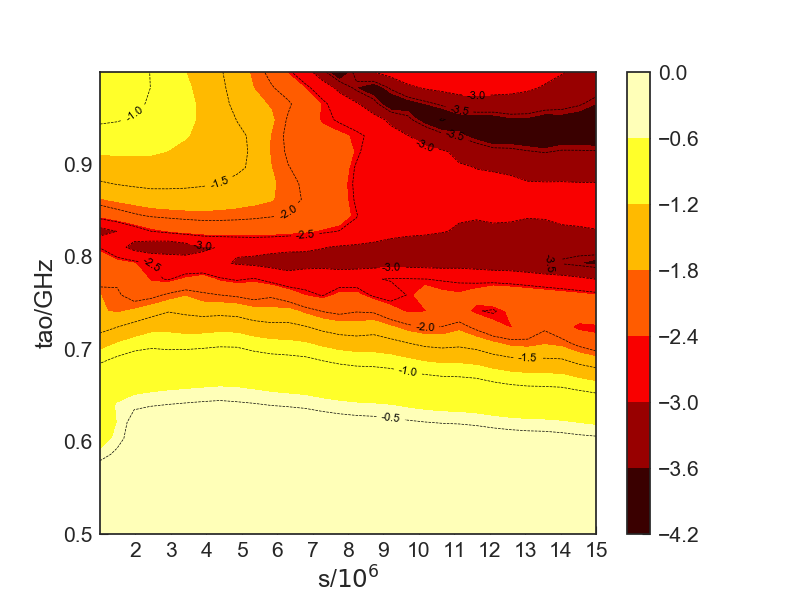

<a list of 16 text.Text objects>

In [8]:
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(1,15,30) 
y = np.linspace(0.5,1,30)
X,Y = np.meshgrid(x,y)

plt.figure(figsize=(8,6))
plt.xlabel('s/$10^{6}$')
plt.ylabel('tao/GHz')
my_x_ticks = np.arange(2, 16, 1)
my_y_ticks = np.arange(0.5, 1, 0.1)
plt.xticks(my_x_ticks)
plt.yticks(my_y_ticks)
plt.contourf(X, Y, array, origin='lower', cmap=plt.get_cmap('hot'))
plt.colorbar()
cntr = plt.contour(X, Y, array, 8, colors='black',linewidths=0.5)
plt.clabel(cntr, inline_spacing=1, fmt='%.1f', fontsize=8)

In [26]:
psi0=basis(8,0) #initial state
population=basis(8,2)*basis(8,2).dag()
# H, c_ops = Hamiltonian(0.6e-9,10e6,120,8.75,10)
# output = mesolve(H, psi0, t, c_ops, population)
# tao = 1e-9
# Delta = 120 #GHz
t = np.linspace(0, 0.5e-9, 20)

Array = np.zeros((30,30))
ss = np.linspace(10,100,30) 
ddelta = np.linspace(6,15,30)
for i,s in enumerate(ss):
    for j,delta in enumerate(ddelta):
        H, c_ops = Hamiltonian(0.3e-9, s*1e6, 120, delta, 10)  
        output = mesolve(H, psi0, t, c_ops, population)
        Array[i][j] = np.log10(1-max(output.expect[0]))

<IPython.core.display.Javascript object>


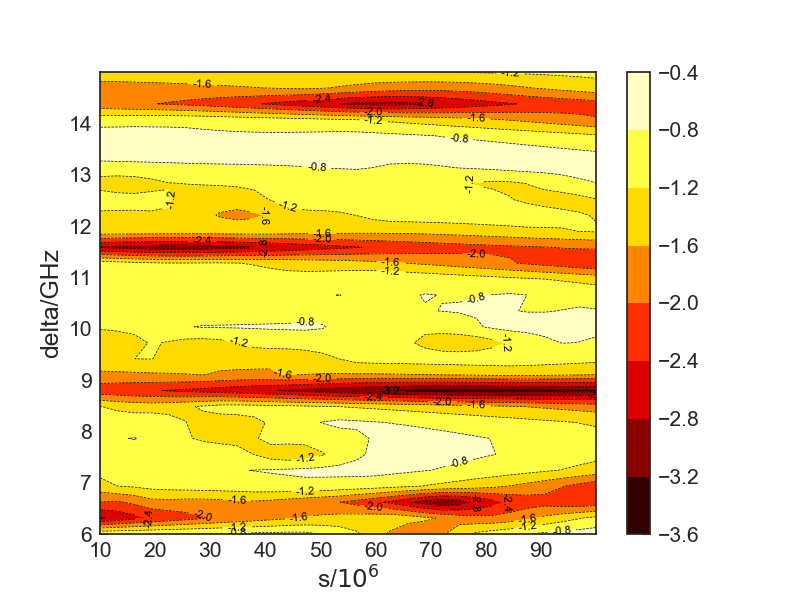

<a list of 46 text.Text objects>

In [61]:
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(10,100,30) 
y = np.linspace(6,15,30)
X,Y = np.meshgrid(x,y)

plt.figure(figsize=(8,6))
plt.xlabel('s/$10^{6}$')
plt.ylabel('delta/GHz')
my_x_ticks = np.arange(10, 100, 10)
my_y_ticks = np.arange(6, 15, 1)
plt.xticks(my_x_ticks)
plt.yticks(my_y_ticks)
plt.contourf(X, Y, Array, origin='lower', cmap=plt.get_cmap('hot'))
plt.colorbar()
cntr = plt.contour(X, Y, Array, 8, colors='black',linewidths=0.5)
plt.clabel(cntr, inline_spacing=1, fmt='%.1f', fontsize=8)

In [159]:
Array = np.zeros((20,20))
ddetuning = np.linspace(2,10,20) 
ddelta = np.linspace(100,150,20)
for i,detuning in enumerate(ddetuning):
    for j,delta in enumerate(ddelta):
        H, c_ops = Hamiltonian(0.2e-9, 20*1e6, delta, detuning, 10)  
        output = mesolve(H, psi0, t, c_ops, population)
        Array[i][j] = np.log10(1-max(output.expect[0]))

<IPython.core.display.Javascript object>


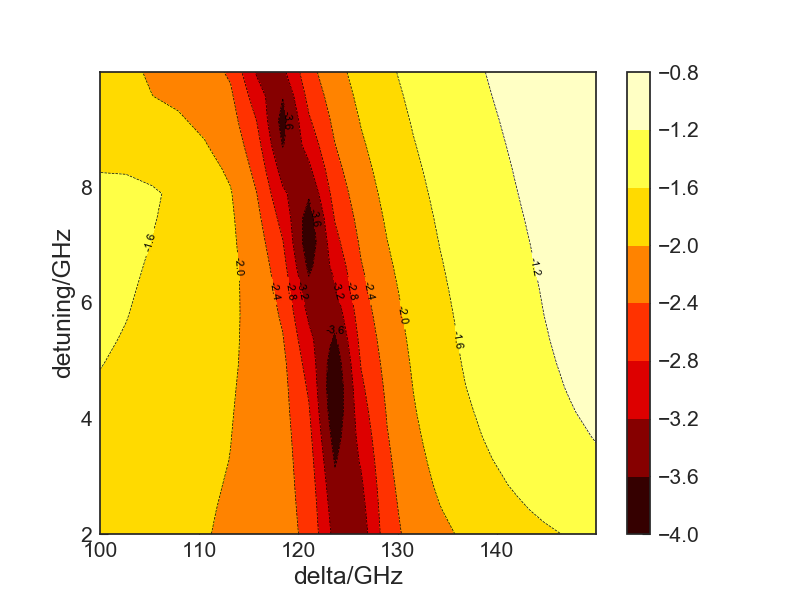

<a list of 14 text.Text objects>

In [160]:
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(100,150,20) 
y = np.linspace(2,10,20)
X,Y = np.meshgrid(x,y)

plt.figure(figsize=(8,6))
plt.ylabel('detuning/GHz')
plt.xlabel('delta/GHz')
my_x_ticks = np.arange(100,150,10)
my_y_ticks = np.arange(2,10,2)
plt.xticks(my_x_ticks)
plt.yticks(my_y_ticks)
plt.contourf(X, Y, Array, origin='lower', cmap=plt.get_cmap('hot'))
plt.colorbar()
cntr = plt.contour(X, Y, Array, 8, colors='black',linewidths=0.5)
plt.clabel(cntr, inline_spacing=1, fmt='%.1f', fontsize=8)

In [137]:
Array = np.zeros((20,20))
ddetuning = np.linspace(7,7.1,20) 
ddelta = np.linspace(117,125,20)
for i,detuning in enumerate(ddetuning):
    for j,delta in enumerate(ddelta):
        H, c_ops = Hamiltonian(0.2e-9, 20*1e6, delta, detuning, 10)  
        output = mesolve(H, psi0, t, c_ops, population)
        Array[i][j] = np.log10(1-max(output.expect[0]))

<IPython.core.display.Javascript object>


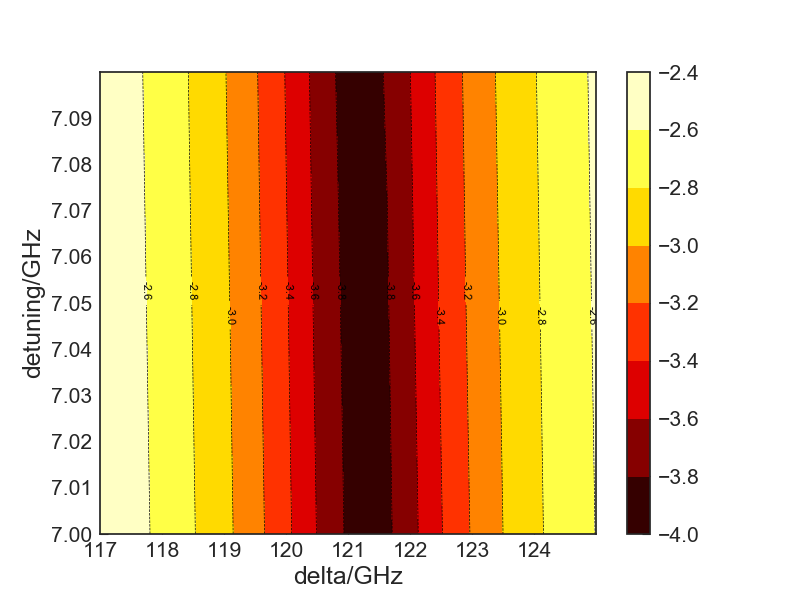

<a list of 14 text.Text objects>

In [143]:
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(117,125,20) 
y = np.linspace(7,7.1,20)
X,Y = np.meshgrid(x,y)

plt.figure(figsize=(8,6))
plt.ylabel('detuning/GHz')
plt.xlabel('delta/GHz')
my_x_ticks = np.arange(117, 125, 1)
my_y_ticks = np.arange(7, 7.1, 0.01)
plt.xticks(my_x_ticks)
plt.yticks(my_y_ticks)
plt.contourf(X, Y, Array, origin='lower', cmap=plt.get_cmap('hot'))
plt.colorbar()
cntr = plt.contour(X, Y, Array, 8, colors='black',linewidths=0.5)
plt.clabel(cntr, inline_spacing=1, fmt='%.1f', fontsize=8)

/Users/apple/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/Users/apple/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:98: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


<IPython.core.display.Javascript object>


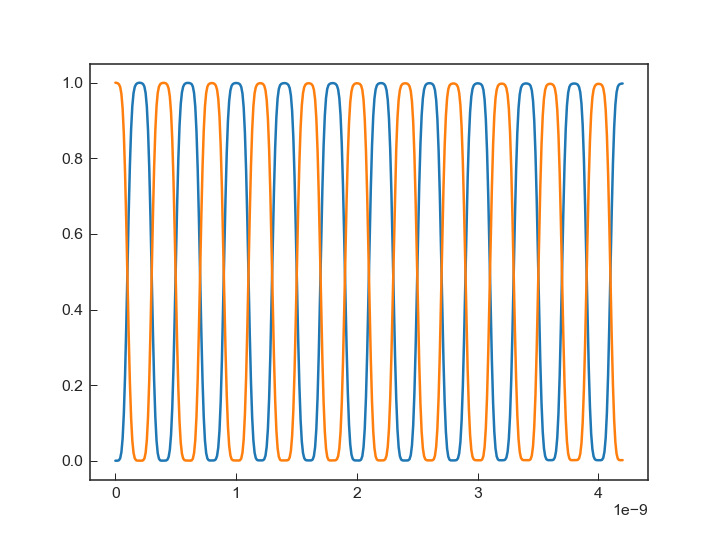

0.0 1.0
0.00013923156623296684 20
0.00016103507552790838 38
0.0005038887335260256 60
0.0005753635671358319 78
0.0008416117422900271 100
0.0008247819820656096 119
0.0010460410421903044 140
0.0007258687564388554 161
0.0011231799399941123 179
0.0005278722183318921 201
0.0011365180668685415 219
0.000553986334912206 239
0.0013359816876734598 259
0.0007440129724535975 278
0.0016484018972724446 299
0.001129147939025853 318
0.001963046502788557 339
0.0013767864289157378 360
0.002138417731466169 379
0.0012891344570412453 400
---------
9.234615988485435e-05 21
0.0004208006748321891 40
0.00020398451155883562 62
0.0009505469884918405 80
0.0005335454079377567 102
0.001399899307061303 120
0.0007025392695702101 138
0.0014925730510810808 160
0.0006492452719896775 177
0.0015467519006489017 199
0.0007343696410008169 218
0.0016661157506303592 239
0.0008647517391711316 261
0.0020489420984790563 279
0.0010472739577005853 301
0.002561068513470044 319
0.0013528188505709192 341
0.00294460457746204 359
0.00142

In [614]:
psi0=basis(8,0) #initial state
psi1=basis(8,2)
population=basis(8,2)*basis(8,2).dag()
H, c_ops = Hamiltonian(0.2e-9,20e6,121.5,7.05,10)
t = np.linspace(0, 4.2e-9, 420)
output = mesolve(H, psi0, t, c_ops, population)
output1 = mesolve(H, psi1, t, c_ops, population)
plt.figure()
plt.plot(t,output.expect[0])
plt.plot(t,output1.expect[0])
p=[]
p1=[]
print(output.expect[0][0],output1.expect[0][0])
for i in range(10):
    print(1-max(output.expect[0][0+40*i:39+40*i]),list(output.expect[0]).index(max(output.expect[0][0+40*i:39+40*i])))
    print(min(output.expect[0][19+40*i:59+40*i]),list(output.expect[0]).index(min(output.expect[0][19+40*i:59+40*i])))
    p.append(1-max(output.expect[0][0+40*i:39+40*i]))
    p.append(min(output.expect[0][19+40*i:59+40*i]))
print('---------')
for i in range(10):
    print(min(output1.expect[0][0+40*i:39+40*i]),list(output1.expect[0]).index(min(output1.expect[0][0+40*i:39+40*i])))
    print(1-max(output1.expect[0][19+40*i:59+40*i]),list(output1.expect[0]).index(max(output1.expect[0][19+40*i:59+40*i])))
    p1.append(min(output1.expect[0][0+40*i:39+40*i]))
    p1.append(1-max(output1.expect[0][19+40*i:59+40*i]))

In [595]:
print(p)
print(p1)

[0.0001394651445725259, 0.00015708243117244655, 0.0005249213844928935, 0.0005575077525994775, 0.0009080133612549002, 0.0008244531793706473, 0.0010408394167522594, 0.0007305221201447415, 0.0010482039518333597, 0.0005221168210293375]
[9.129491020497352e-05, 0.0004353642953244252, 0.00020369254983836066, 0.0009939967993850551, 0.0005510490828068025, 0.0014265821176313587, 0.0006541807506955855, 0.0014950078063995509, 0.000588817160067621, 0.001454019927007777]


<IPython.core.display.Javascript object>


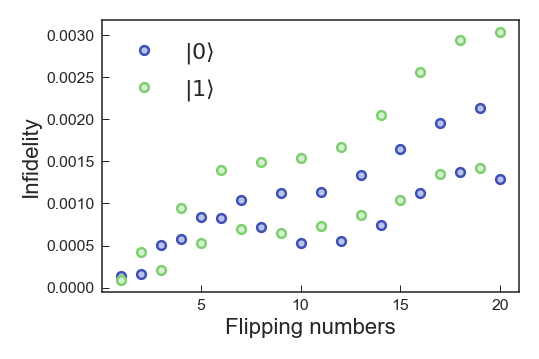

In [606]:
fig10, ax10 = plt.subplots(figsize=(6,4))
plt.plot(range(1,21), p, 'o',ms=7,markeredgewidth=2, markeredgecolor='#3F51B5', markerfacecolor='#BBC2E7',label=r'$|0\rangle$')
plt.plot(range(1,21), p1, 'o',ms=7,markeredgewidth=2, markeredgecolor='#80ce72', markerfacecolor='#d5efd1',label=r'$|1\rangle$')
plt.xlabel('Flipping numbers')
plt.ylabel('Infidelity')
plt.tight_layout()
plt.legend(frameon=False)

In [172]:
psi0=basis(8,0) #initial state
population=basis(8,2)*basis(8,2).dag()
# H, c_ops = Hamiltonian(0.6e-9,10e6,120,8.75,10)
# output = mesolve(H, psi0, t, c_ops, population)
# tao = 1e-9
# Delta = 120 #GHz
t = np.linspace(0, 0.3e-9, 20)

Array = np.zeros((20,20))
ddetuning = np.linspace(2,10,20) 
ddelta = np.linspace(20,160,20)
for i,detuning in enumerate(ddetuning):
    for j,delta in enumerate(ddelta):
        H, c_ops = Hamiltonian(0.2e-9, 10*1e6, delta, detuning, 10)  
        output = mesolve(H, psi0, t, c_ops, population)
        Array[i][j] = np.log10(1-max(output.expect[0]))

<IPython.core.display.Javascript object>


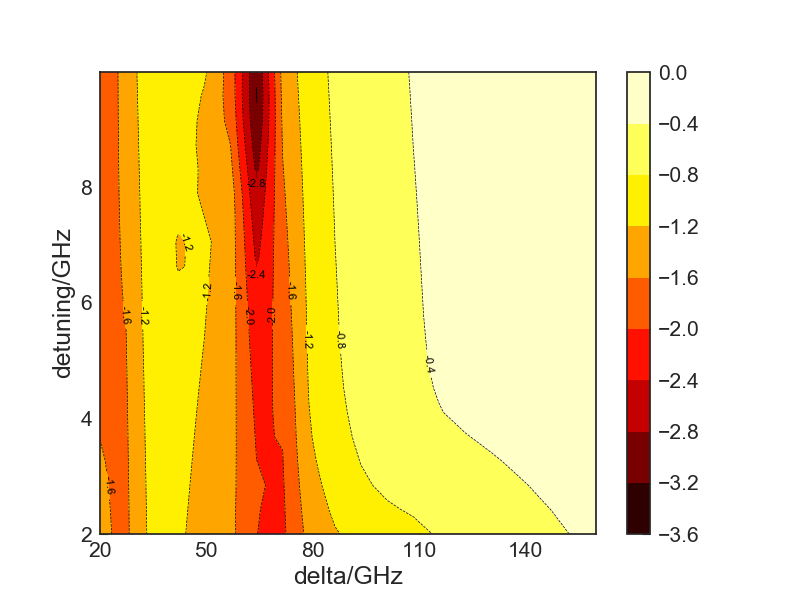

<a list of 14 text.Text objects>

In [174]:
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(20,160,20) 
y = np.linspace(2,10,20)
X,Y = np.meshgrid(x,y)

plt.figure(figsize=(8,6))
plt.ylabel('detuning/GHz')
plt.xlabel('delta/GHz')
my_x_ticks = np.arange(20,160,30)
my_y_ticks = np.arange(2,10,2)
plt.xticks(my_x_ticks)
plt.yticks(my_y_ticks)
plt.contourf(X, Y, Array, origin='lower', cmap=plt.get_cmap('hot'))
plt.colorbar()
cntr = plt.contour(X, Y, Array, 8, colors='black',linewidths=0.5)
plt.clabel(cntr, inline_spacing=1, fmt='%.1f', fontsize=8)

In [110]:
psi0=basis(8,0) #initial state
population=basis(8,2)*basis(8,2).dag()
# H, c_ops = Hamiltonian(0.6e-9,10e6,120,8.75,10)
# output = mesolve(H, psi0, t, c_ops, population)
# tao = 1e-9
# Delta = 120 #GHz
t = np.linspace(0, 0.3e-9, 20)

Array = np.zeros((20,20))
ddetuning = np.linspace(2,2.5,20) 
ddelta = np.linspace(20,90,20)
for i,detuning in enumerate(ddetuning):
    for j,delta in enumerate(ddelta):
        H, c_ops = Hamiltonian(0.2e-9, 10*1e6, delta, detuning, 10)  
        output = mesolve(H, psi0, t, c_ops, population)
        Array[i][j] = np.log10(1-max(output.expect[0]))

<IPython.core.display.Javascript object>


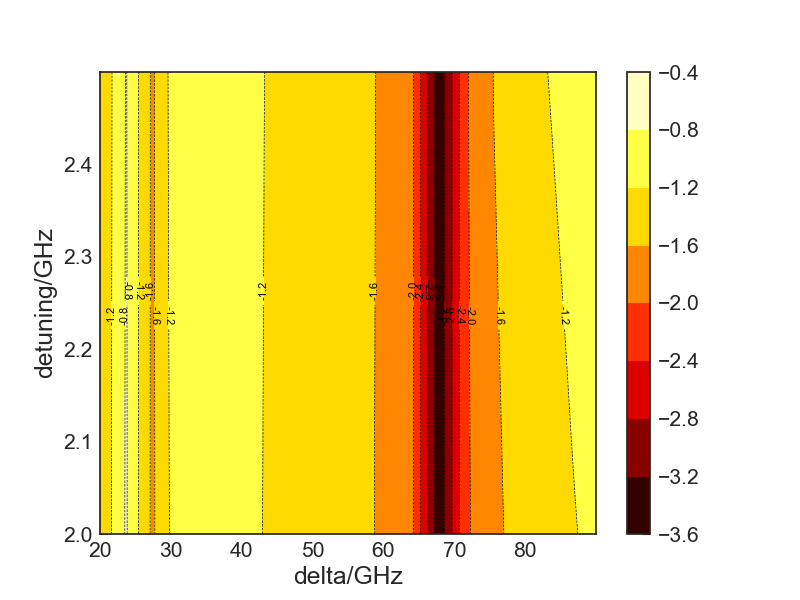

<a list of 19 text.Text objects>

In [127]:
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(20,90,20) 
y = np.linspace(2,2.5,20)
X,Y = np.meshgrid(x,y)

plt.figure(figsize=(8,6))
plt.xlabel('delta/GHz')
plt.ylabel('detuning/GHz')
my_x_ticks = np.arange(20, 90, 10)
my_y_ticks = np.arange(2, 2.5, 0.1)
plt.xticks(my_x_ticks)
plt.yticks(my_y_ticks)
plt.contourf(X, Y, Array, origin='lower', cmap=plt.get_cmap('hot'))
plt.colorbar()
cntr = plt.contour(X, Y, Array, 8, colors='black',linewidths=0.5)
plt.clabel(cntr, inline_spacing=1, fmt='%.1f', fontsize=8)

<IPython.core.display.Javascript object>


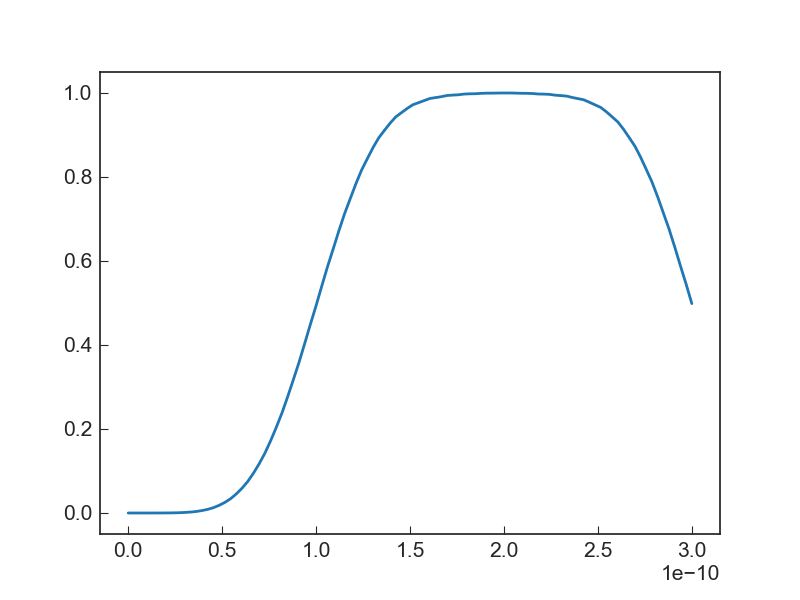

0.99979889483563511

In [166]:
psi0=basis(8,0) #initial state
population=basis(8,2)*basis(8,2).dag()
H, c_ops = Hamiltonian(0.2e-9,10e6,68,2.3,10)
t = np.linspace(0, 0.3e-9, 100)
output = mesolve(H, psi0, t, c_ops, population)
plt.figure()
plt.plot(t,output.expect[0])
max(output.expect[0])

In [148]:
psi0=basis(8,0) #initial state
population=basis(8,2)*basis(8,2).dag()
# H, c_ops = Hamiltonian(0.6e-9,10e6,120,8.75,10)
# output = mesolve(H, psi0, t, c_ops, population)
# tao = 1e-9
# Delta = 120 #GHz
t = np.linspace(0, 0.3e-9, 20)

Array = np.zeros((20,20))
ddetuning = np.linspace(0.5,2,20) 
ddelta = np.linspace(20,60,20)
for j,detuning in enumerate(ddetuning):
    for i,delta in enumerate(ddelta):
        H, c_ops = Hamiltonian(0.2e-9, 5*1e6, delta, detuning, 10)  
        output = mesolve(H, psi0, t, c_ops, population)
        Array[i][j] = np.log10(1-max(output.expect[0]))

<IPython.core.display.Javascript object>


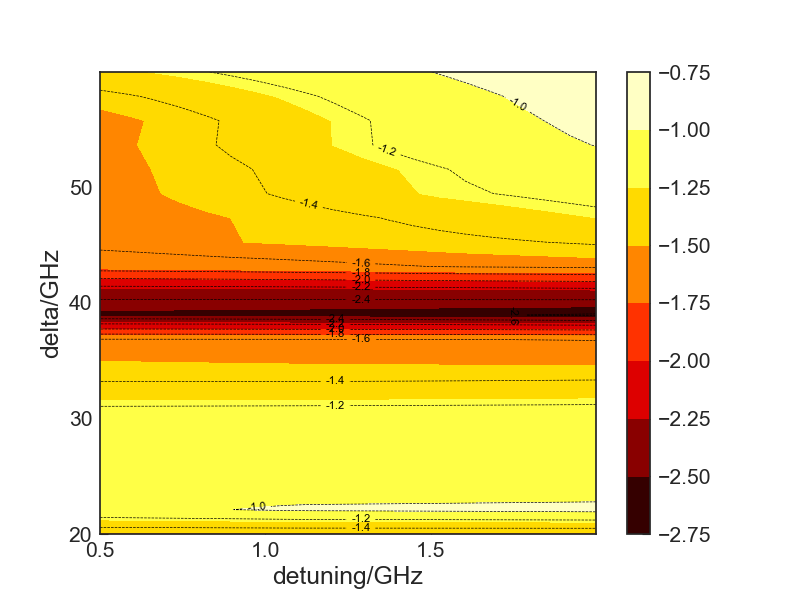

<a list of 19 text.Text objects>

In [153]:
import numpy as np
import matplotlib.pyplot as plt

y = np.linspace(20,60,20) 
x = np.linspace(0.5,2,20)
X,Y = np.meshgrid(x,y)

plt.figure(figsize=(8,6))
plt.ylabel('delta/GHz')
plt.xlabel('detuning/GHz')
my_y_ticks = np.arange(20, 60, 10)
my_x_ticks = np.arange(0.5, 2, 0.5)
plt.xticks(my_x_ticks)
plt.yticks(my_y_ticks)
plt.contourf(X, Y, Array, origin='lower', cmap=plt.get_cmap('hot'))
plt.colorbar()
cntr = plt.contour(X, Y, Array, 8, colors='black',linewidths=0.5)
plt.clabel(cntr, inline_spacing=1, fmt='%.1f', fontsize=8)

<IPython.core.display.Javascript object>


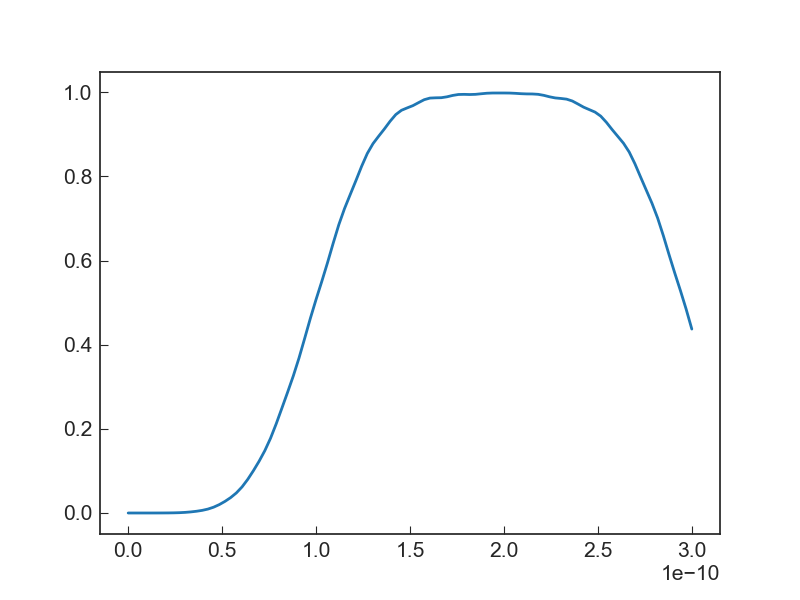

0.99807323395353831

In [155]:
psi0=basis(8,0) #initial state
population=basis(8,2)*basis(8,2).dag()
H, c_ops = Hamiltonian(0.2e-9,5e6,39,1.25,10)
t = np.linspace(0, 0.3e-9, 100)
output = mesolve(H, psi0, t, c_ops, population)
plt.figure()
plt.plot(t,output.expect[0])
max(output.expect[0])

In [163]:
np.exp(2)

7.3890560989306504